In [1]:
import tensorflow as tf
x=tf.Variable(3,'x')
y=tf.Variable(4,'y')
f=x*x*y+y+2
sess=tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result=sess.run(f)
sess.close()

or alternative , we can use this

In [2]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result=f.eval()
    

In [3]:
result

42

and actually you can create a init node to initialize all the varivables

In [4]:
init=tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()  # initialize all the variables
    result=f.eval()

In [5]:
result

42

In [6]:
sess=tf.InteractiveSession() #it's a default session
init.run()
result=f.eval()
sess.close()

In [7]:
x1=tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [8]:
graph=tf.Graph()
with graph.as_default():
    x2=tf.Variable(2)

x2.graph is tf.get_default_graph()

False

In [9]:
x2.graph is graph

True

and more multiple sessions do not share variables

In [10]:
w=tf.constant(3)
x=w + 2
y=x + 5
z=x * 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

10
15


or

In [11]:
with tf.Session() as sess:
    y_val, z_val= sess.run([y,z])

In [12]:
y_val

10

## LinearRegression with Tensorflow

In [13]:
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
m,n=housing["data"].shape

In [14]:
m,n

(20640, 8)

In [15]:
housing_data_bias=np.c_[np.ones((m,1)),housing["data"]]
X=tf.constant(housing_data_bias,dtype=tf.float32,name="X")
y=tf.constant(housing["target"].reshape(-1,1),dtype=tf.float32,name="y")
XT=tf.transpose(X)
theta=tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)),XT),y)

with tf.Session() as sess:
    theta_value=theta.eval()

In [16]:
theta_value

array([[ -3.74651413e+01],
       [  4.35734153e-01],
       [  9.33829229e-03],
       [ -1.06622010e-01],
       [  6.44106984e-01],
       [ -4.25131839e-06],
       [ -3.77322501e-03],
       [ -4.26648885e-01],
       [ -4.40514028e-01]], dtype=float32)

## Gradient descent

Gradient descent need data to be normalized

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [18]:
n_epochs = 1000
learning_rate = 0.01
#initialize
X=tf.constant(scaled_housing_data_plus_bias,dtype=tf.float32,name="X")
y=tf.constant(housing["target"].reshape(-1,1),dtype=tf.float32,name="y")
theta=tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0,seed=42),name="theta")
y_pred=tf.matmul(X,theta,name="prediction")
error=y_pred-y
mse=tf.reduce_mean(tf.square(error),name="mse")
gradients=(2/m)*tf.matmul(tf.transpose(X),error)
training_op=tf.assign(theta,theta-learning_rate*gradients)
#set up initializer
init=tf.global_variables_initializer()
#run the tensorflow
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        if epoch%100==0:
            print("Epoch",epoch,"mse=",mse.eval())
        sess.run(training_op)
        
    best_theta=theta.eval()

Epoch 0 mse= 2.75443
Epoch 100 mse= 0.632222
Epoch 200 mse= 0.57278
Epoch 300 mse= 0.558501
Epoch 400 mse= 0.54907
Epoch 500 mse= 0.542288
Epoch 600 mse= 0.537379
Epoch 700 mse= 0.533822
Epoch 800 mse= 0.531243
Epoch 900 mse= 0.529371


In [19]:
best_theta

array([[  2.06855226e+00],
       [  7.74078071e-01],
       [  1.31192401e-01],
       [ -1.17845066e-01],
       [  1.64778143e-01],
       [  7.44081335e-04],
       [ -3.91945131e-02],
       [ -8.61356676e-01],
       [ -8.23479772e-01]], dtype=float32)

and we can use autodiff to make the code sufficient

In [20]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.1
#initialize
X=tf.constant(scaled_housing_data_plus_bias,dtype=tf.float32,name="X")
y=tf.constant(housing["target"].reshape(-1,1),dtype=tf.float32,name="y")
theta=tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0,seed=42),name="theta")
y_pred=tf.matmul(X,theta,name="prediction")
error=y_pred-y
mse=tf.reduce_mean(tf.square(error),name="mse")
gradients=tf.gradients(mse,[theta])[0] #gradient's shape is (9,1)
training_op=tf.assign(theta,theta-learning_rate*gradients)

init=tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        if epoch%100==0 :
            print("Epoch",epoch,"Mse=",mse.eval())
        sess.run(training_op)
    best_theta=theta.eval()

Epoch 0 Mse= 2.75443
Epoch 100 Mse= 0.527928
Epoch 200 Mse= 0.524498
Epoch 300 Mse= 0.524334
Epoch 400 Mse= 0.524323
Epoch 500 Mse= 0.524321
Epoch 600 Mse= 0.524321
Epoch 700 Mse= 0.524321
Epoch 800 Mse= 0.524321
Epoch 900 Mse= 0.524321


How could you find the partial derivatives of the following function with regards to a and b?


In [21]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

In [22]:
tf.reset_default_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z=a*tf.cos(z+i)+z*tf.sin(b-i)
grad=tf.gradients(z,[a,b])

init=tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print("z:",z.eval())
    print("grad",sess.run(grad))

z: -0.212537
grad [-1.1388495, 0.19671397]


and you can use a gradient descent optimizer to calcaulate the gradient descent

In [23]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.1
#initialize
X=tf.constant(scaled_housing_data_plus_bias,dtype=tf.float32,name="X")
y=tf.constant(housing["target"].reshape(-1,1),dtype=tf.float32,name="y")
theta=tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0,seed=42),name="theta")
y_pred=tf.matmul(X,theta,name="prediction")
error=y_pred-y
mse=tf.reduce_mean(tf.square(error),name="mse")
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
training_op = optimizer.minimize(mse)

init=tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        if epoch%100 == 0 :
            print("Epoch",epoch,"Mse=",mse.eval())
        sess.run(training_op)
    best_theta=theta.eval()

Epoch 0 Mse= 2.75443
Epoch 100 Mse= 0.524343
Epoch 200 Mse= 0.524321
Epoch 300 Mse= 0.524321
Epoch 400 Mse= 0.524321
Epoch 500 Mse= 0.524321
Epoch 600 Mse= 0.524321
Epoch 700 Mse= 0.524321
Epoch 800 Mse= 0.524321
Epoch 900 Mse= 0.524321


in deep learning the input and output always change ,so we use the placeholder node and can change the value of node in session execution

In [24]:
A=tf.placeholder(tf.float32,shape=(None,3))
B=A + 5
with tf.Session() as sess:
    B_val_1=B.eval(feed_dict={A:[[1,2,3]]})
    B_val_2=B.eval(feed_dict={A:[[4,5,6],[7,8,9]]})

B_val_1

array([[ 6.,  7.,  8.]], dtype=float32)

In [25]:
C=np.array([[1,2,3]])
C.shape

(1, 3)

In [26]:
np.random.randint(1,100)

1

## Tensorflow for mini-batch gradient

In [27]:
tf.reset_default_graph()

def fetch_batch(epoch, batch_id, batch_size):
    np.random.seed(epoch)
    shuffle_indice=np.random.permutation(m)
    X_scaled=scaled_housing_data_plus_bias[shuffle_indice]
    y_scaled=housing["target"].reshape(-1,1)[shuffle_indice]
    if batch_id < n_batches-1 :
        X_batch=X_scaled[batch_id*batch_size:(batch_id+1)*batch_size]
        y_batch=y_scaled[batch_id*batch_size:(batch_id+1)*batch_size]
    if batch_id==n_batches-1:
        X_batch=X_scaled[(batch_id-1)*batch_size:m]
        y_batch=y_scaled[(batch_id-1)*batch_size:m]
    return X_batch,y_batch
        
    
n_epochs=10
learning_rate=0.01
batch_size=100
n_batches=int(np.ceil(m/100))
#initialize
X=tf.placeholder(tf.float32,shape=(None, n+1),name="X")
y=tf.placeholder(tf.float32,shape=(None,1),name="y")
theta=tf.Variable(tf.random_uniform([n+1,1],-1.0,1.0,seed=42),name="theta")
y_pred=tf.matmul(X,theta,name="prediction")
error=y_pred-y
mse=tf.reduce_mean(tf.square(error),name="mse")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
training_op = optimizer.minimize(mse)

init=tf.global_variables_initializer()
#execution phase
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_id in range(n_batches):
            X_batch,y_batch=fetch_batch(epoch, batch_id, batch_size)
            #print("Epoch",epoch,"mse=",mse.eval(feed_dict={X:X_batch,y:y_batch}))
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
    best_theta=theta.eval()
            
            
        

In [28]:
np.random.seed(42)
np.random.randint(100,size=10)

array([51, 92, 14, 71, 60, 20, 82, 86, 74, 74])

## Visualizing graph

In [29]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [30]:
show_graph(tf.get_default_graph())

then we try to use tensorboard

In [31]:
tf.reset_default_graph()
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "C:\\Users\\hasee\\workspace\\Kaggle\\handson\\Part2\\Chapter9"
logdir = "{}/run-{}/".format(root_logdir, now)

use timedate to make the file unique

In [32]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [33]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [34]:

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [35]:
with tf.Session() as sess:                                                        
    sess.run(init)                                                                

    for epoch in range(n_epochs):                                                
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()   

In [36]:
file_writer.close()

open cmd and type to open tensorboard:** tensorboard --logdir tf_logs/ **

## Add Name Scops

In [37]:
tf.reset_default_graph()
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "C:\\Users\\hasee\\workspace\\Kaggle\\handson\\Part2\\Chapter9"
logdir = "{}/run-{}/".format(root_logdir, now)
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [38]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))
with tf.Session() as sess:                                                        
    sess.run(init)                                                                

    for epoch in range(n_epochs):                                                
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()  
    
file_writer.close()

## Modularity

create a graph that adds the output of two rectified linear units
(ReLU)

first use a function to implement

In [39]:
tf.reset_default_graph()
def RELU(X):
    w_shape=(int(X.get_shape()[1]),1)
    w=tf.Variable(tf.random_normal(w_shape,1,seed=42),name="w")
    b=tf.Variable(0.0,name="bias")
    z=tf.add(tf.matmul(X,w),b,name="z")
    return tf.maximum(z,0.,name="relu")

In [40]:
n_features=3
X=tf.placeholder(tf.float32,shape=(None,n_features),name="X")
relus=[RELU(X) for i in range(5)]
output=tf.add_n(relus,name="output") #tf.add_n([add1 add2])= add1+add2

init=tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    print(output.eval(feed_dict={X:[[1,1,1]]}))

[[ 9.52571678]]


In [41]:
X=np.array([1,2,3])
X.shape

(3,)

In [42]:
file_writer = tf.summary.FileWriter("logs/relu2", tf.get_default_graph())

and also you can add name scope

In [43]:
tf.reset_default_graph()
def RELU(X):
    with tf.name_scope("relu"):
        w_shape=(int(X.get_shape()[1]),1)
        w=tf.Variable(tf.random_normal(w_shape,1,seed=42),name="w")
        b=tf.Variable(0.0,name="bias")
        z=tf.add(tf.matmul(X,w),b,name="z")
        return tf.maximum(z,0.,name="relu")

In [44]:
n_features=3
X=tf.placeholder(tf.float32,shape=(None,n_features),name="X")
relus=[RELU(X) for i in range(5)]
output=tf.add_n(relus,name="output") #tf.add_n([add1 add2])= add1+add2

init=tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    print(output.eval(feed_dict={X:[[1,1,1]]}))

[[ 9.52571678]]


In [45]:
file_writer = tf.summary.FileWriter("logs/relu3", tf.get_default_graph())

# Extra Exercise


try to use tensorflow to implement logistic regression

In [46]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

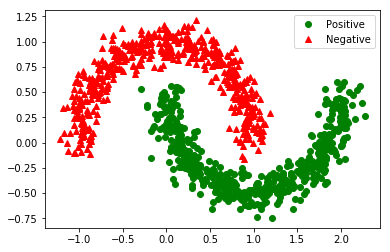

In [47]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [48]:
X_moons_with_bias=np.c_[np.ones((m,1)),X_moons]

In [49]:
X_moons_with_bias.shape

(1000, 3)

In [50]:
y_moons_column_vector=y_moons.reshape(-1,1)

In [51]:
test_ratio=0.2
test_size=int(m*test_ratio)
X_train=X_moons_with_bias[:-test_size]
X_test=X_moons_with_bias[-test_size:]
y_train=y_moons_column_vector[:-test_size]
y_test=y_moons_column_vector[-test_size:]

In [52]:
def Random_batch(X,y,batch_size):
    #X_shuffle=np.random.permutation(X)
    #y_shuffle=np.random.permutation(y)
    #X_batch=X_shuffle[:batch_size]
    #y_batch=y_shuffle[:batch_size]
    #return X_batch,y_batch
    shuffle_indice=np.random.randint(0,len(X),batch_size)
    X_batch=X[shuffle_indice]
    y_batch=y[shuffle_indice]
    return X_batch,y_batch

now we start tensorflow code

In [53]:
tf.reset_default_graph()
np.random.seed(42)
#graph phase
learning_rate=0.01

n_features=2
X=tf.placeholder(tf.float32,shape=(None,n_features+1),name="X")
y=tf.placeholder(tf.float32,shape=(None,1),name="y")
theta=tf.Variable(tf.random_uniform([n_features+1,1],-1.0,1.0,seed=42),name="theta")
logit=tf.matmul(X,theta)
#y_pred=1/(1+tf.exp(-logit))
y_pred=tf.sigmoid(logit)
epsilon=1e-7
#loss=-tf.reduce_mean(y*tf.log(y_pred+epsilon)+(1-y)*tf.log(1-y_pred+epilson))
loss=tf.losses.log_loss(y,y_pred)
optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op=optimizer.minimize(loss)

init=tf.global_variables_initializer()
#Execution phase

n_epochs=1000
batch_size=50
n_batches=int(np.ceil(m/batch_size))

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for batch in range(n_batches):
            X_batch,y_batch=Random_batch(X_train,y_train,batch_size)
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        loss_val=loss.eval(feed_dict={X:X_test,y:y_test})
        if epoch%100==0 :
            print("Epoch",epoch,"loss",loss_val)
            
    y_pred_val = y_pred.eval(feed_dict={X: X_test, y: y_test})
            
    
    
    

    


Epoch 0 loss 0.877019
Epoch 100 loss 0.35205
Epoch 200 loss 0.310993
Epoch 300 loss 0.29464
Epoch 400 loss 0.286309
Epoch 500 loss 0.281046
Epoch 600 loss 0.278434
Epoch 700 loss 0.27638
Epoch 800 loss 0.275664
Epoch 900 loss 0.275004


In [54]:
X=[1,2,3]
X[:1]

[1]

In [55]:
y_pred_val[:5]

array([[ 0.54818761],
       [ 0.70775223],
       [ 0.5182308 ],
       [ 0.99098408],
       [ 0.50884157]], dtype=float32)

In [56]:
y_pred_out=(y_pred_val>=0.5)

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_test, y_pred_out)


0.86274509803921573

In [58]:
recall_score(y_test,y_pred_out)

0.88888888888888884

In [59]:
f1_score(y_test,y_pred_out)

0.87562189054726369

Well, that looks pretty bad, doesn't it? But let's not forget that the Logistic Regression model has a linear decision boundary, so this is actually close to the best we can do with this model (unless we add more features, as we will show in a second).
Now let's start over, but this time we will add all the bells and whistles, as listed in the exercise:
- Define the graph within a logistic_regression() function that can be reused easily.
- Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.
- Restore the last checkpoint upon startup if training was interrupted.
- Define the graph using nice scopes so the graph looks good in TensorBoard.
- Add summaries to visualize the learning curves in TensorBoard.
- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

Before we start, we will add 4 more features to the inputs: ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ and ${x_2}^3$. This was not part of the exercise, but it will demonstrate how adding features can improve the model. We will do this manually, but you could also add them using sklearn.preprocessing.PolynomialFeatures.

In [60]:
from sklearn.preprocessing import PolynomialFeatures
poly_feature=PolynomialFeatures(degree=2,include_bias=False)
X_poly_train=poly_feature.fit_transform(X_train)
X_poly_test=poly_feature.fit_transform(X_test)

In [61]:
X_poly_train.shape

(800, 9)

In [62]:
tf.reset_default_graph()

def Logistic_regression(X,y,learning_rate,initializer=None):
    n_inputs_including_bias=int(X.get_shape()[1])#in tensorflow should use get_shape()
    with tf.name_scope("Logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer=tf.random_uniform([n_inputs_including_bias,1],-1.0,1.0,seed=42)
            theta=tf.Variable(initializer,name="theta")
            logit=tf.matmul(X,theta,name="logit")
            y_prob=tf.sigmoid(logit)
        with tf.name_scope("train"):
            loss=tf.losses.log_loss(y,y_prob,scope="loss")
            optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            traning_op=optimizer.minimize(loss)
            loss_summary=tf.summary.scalar("log_loss",loss)
        with tf.name_scope("init"):
            init=tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_prob, loss, training_op, loss_summary, init, saver

from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_log_reg"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [63]:
#graph phase
n_features=9
logdir=log_dir("logreg")
learining_rate=0.01

X=tf.placeholder(tf.float32,shape=(None,n_features),name="X")
y=tf.placeholder(tf.float32,shape=(None,1),name="y")

y_prob, loss, training_op, loss_summary, init, saver=Logistic_regression(X,y,learning_rate=learning_rate)

file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())

In [64]:
#execution phase
import os
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "C:\\Users\\hasee\\workspace\\Kaggle\\handson\\Part2\\Chapter9\\tmp\\my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "C:\\Users\\hasee\\workspace\\Kaggle\\handson\\Part2\\Chapter9\\my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
        
    for epoch in range(start_epoch,n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch= Random_batch(X_poly_train,y_train,batch_size)
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        loss_val,summary_str=sess.run([loss,loss_summary],feed_dict={X:X_poly_test,y:y_test})
        file_writer.add_summary(summary_str,epoch)
        if epoch%500==0:
            print("Epoch:",epoch,"loss",loss_val)
            saver.save(sess,checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    
    saver.save(sess,final_model_path)
    y_prob_val=y_prob.eval(feed_dict={X:X_poly_test,y:y_test})
    os.remove(checkpoint_path)


ValueError: Fetch argument <tf.Operation 'GradientDescent' type=NoOp> cannot be interpreted as a Tensor. (Operation name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_theta/ApplyGradientDescent"
 is not an element of this graph.)